# Fitting MRP to the haloes from a BIG simulation suite, simultaneously

In this example, we grab haloes from the publicly available $\nu^2$GC simulation suite and show how MRP can be fit to the haloes of 4 simulations simultaneously. In this case, the 4 simulations have different box sizes, so they probe different parts of the mass function more or less effectively. By combining them, we can get a good handle on a wide range of the mass function.

Do note that this example is not quick. It takes a while to *get* the data, let alone run the MCMC on it. You may want to generate some smaller fake datasets to have a play.

**The plots from this example are used in MRP as Figures 2 and 3.**

## Preparing the data

First you'll need to get the data. These are the files you'll need to download (beware, at least one of them is 12Gb alone):

http://www2.ccs.tsukuba.ac.jp/Astro/Members/ishiyama/nngc/Data/n2gc-m_z0.fof.bz2

http://www2.ccs.tsukuba.ac.jp/Astro/Members/ishiyama/nngc/Data/n2gc-h1_z0.fof.bz2

http://www2.ccs.tsukuba.ac.jp/Astro/Members/ishiyama/nngc/Data/n2gc-m_z0.rockstar.bz2


Then unzip them. We'll assume they've been unzipped to the ``n2gc/`` directory.

In [1]:
# General imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Mrpy imports
from mrpy.fit_perobj import PerObjFit
from mrpy import MRP

First of all, we need to pare down the huge files. We can do this in a few ways:

   * We only care about the Mass column, so we can delete everything else
   * We only care about unique halo masses (and the quantity of each), so we can "tabulate" the data
   * We keep only haloes with 40 or more particles (this limit is taken from the paper accompanying the catalogue)
   
These operations reduce the file size by about a factor of 100-1000, and make the subsequent MCMC runs much faster.

Something else to consider is that the fastest way to read in the data files and reduce them is to do it in one big chunk with numpy. However, this takes a lot of memory. So instead we read them line by line.

With these considerations, we implement the following two functions

In [2]:
def strip_and_compress(fname,fout,mpart=None,Nmin=0,ftype="fof"):
    unique_masses = {}
    
    with open(fname) as fin:
        for line in fin:
            l = line.strip()
            
            # Skip comments
            if l.startswith("#"):
                continue
            
            else:
                if ftype=="fof":
                    npart = int(l.split()[-1])
                elif ftype=="rockstar":
                    npart = int(l.split()[7])
                    
                # Reject the entry if it is less than Nmin
                if npart < Nmin:
                    continue
                    
                # Calculate the mass of the halo
                if ftype=="fof":
                    mvir = mpart * npart
                elif ftype=="rockstar":
                    mvir = float(l.split()[19])
                    
                # Add it to the final unique mass dict
                if mvir in unique_masses:
                    unique_masses[mvir] += 1
                else:
                    unique_masses[mvir] = 1

    # Convert the dict of values into a 2D array of masses and number of occurrences
    out = np.array([[k,v] for k,v in unique_masses.iteritems()])
    
    print "Compressed {} to {} percent".format(fname,100*len(out[:,1])/sum(out[:,1]))
    
    # Save the data to a table file
    np.savetxt(fout,out)

Now actually do the stripping and compressing of the files. We save the data in new files with an appended ".compact".

In [166]:
strip_and_compress("n2gc/n2gc-h1_z0.fof","n2gc/n2gc-h1_z0.fof.compact",2.75e7,40)
strip_and_compress("n2gc/n2gc-m_z0.fof","n2gc/n2gc-m_z0.fof.compact",2.2e8,40)

strip_and_compress("n2gc/n2gc-m_z0.rockstar","n2gc/n2gc-m_z0.rockstar.compact",Nmin=40,ftype="rockstar")

Compressed n2gc/n2gc-h2_z0.fof to 0.658871409115 percent
Compressed n2gc/n2gc-h1_z0.fof to 0.644681006731 percent
Compressed n2gc/n2gc-m_z0.fof to 0.20284837408 percent
Compressed n2gc/n2gc-s_z0.fof to 0.573980387153 percent
Compressed n2gc/n2gc-h2_z0.rockstar to 0.480669073771 percent
Compressed n2gc/n2gc-h1_z0.rockstar to 0.444176240037 percent
Compressed n2gc/n2gc-m_z0.rockstar to 0.101075730761 percent
Compressed n2gc/n2gc-s_z0.rockstar to 0.376734884976 percent


## Running the fits

We'll run the fits with the ``emcee`` package (via a routine built in to ``mrpy``), but also with an optimization solver. The in-built function is able to utilise the tabulation of data we have performed already, and can do the suites simultaneously. We're going to focus on the FoF sims, as that is what is used to get the published mass function for $\nu^2$GC.

First up, read in the compact data we just created.

In [106]:
# Read in the data from file
def get_raw_data(sims=['h1','m'],ftype="fof"):
    m = []
    nm = []
    for sim in sims:
        data = np.genfromtxt("n2gc/n2gc-{}_z0.{}.compact".format(sim,ftype))
        m.append(data[:,0])
        nm.append(data[:,1])
    return m,nm

In [57]:
m,nm = get_raw_data(['h1','m'])
print "Total number of haloes: ", np.sum([np.sum(x) for x in nm])
print "Total number of *unique* haloes: ", np.sum([len(x) for x in m])

Total number of haloes:  58169126.0
Total number of *unique* haloes:  142151


### Exploration of weighting scale

As we begin doing the fitting, there is one primary question that we need to be careful of. Because of the steep decline in number density in the sample towards high masses (for eg. $10^{15}$ mass haloes are more than 100 times more rare than $10^{14}$ mass haloes), very little information comes from the high mass end. This can pose a problem for the estimation of the $\beta$ parameter, which primarily influences this part of the function.

We can self-consistently alleviate this problem by introducing a weighting, in which high-mass haloes contribute more strongly to the likelihood, via a weighting

$$ w \propto m^s, $$

where the ``weight_scale`` *s* is arbitrary, and equals zero to give no weighting. We don't want to set *s* too high, since the high-mass haloes which would then contribute more strongly are also inherently more noisy in terms of Poisson and cosmic variance noise. So what is the correct scale to use? We expect this to depend on the problem at hand.

In this case, since we have small simulations included with big ones, we *a priori* expect the high-mass end to be under-valued, due to finite box size effects. Thus it makes sense that some value higher than 0 will be useful.

One way we can explore the effects relatively quickly is to use downhill gradient methods to fit the solution for several choices of the ``weight_scale``. Note that using downhill gradient methods are not always reliable in terms of finding the posterior distribution and the central estimator of choice. But we neglect these concerns for now.

In [5]:
# A function that runs the downhill gradient optimization for us
def run_downhill(weight_scale):
    # Create the fitting class instance. This will have uniform priors.
    fitobj = PerObjFit(m,nm,weight_scale=weight_scale,
                         alpha_bounds = (-1.99,-1.5), hs_bounds=(12,16),beta_bounds=(0.2,1.5))
    fitobj.run_downhill()
    return fitobj

# A function that runs the optimization for several choices of the scaling
def run_downhill_over_s():
    weight_scales = np.linspace(0,1,10)
    results = []
    for s in weight_scales:
        obj = run_downhill(s)
        results.append(obj.downhill_res.x)
        
    return np.array(results), weight_scales

In [58]:
# Run the different weightings
res,s = run_downhill_over_s()

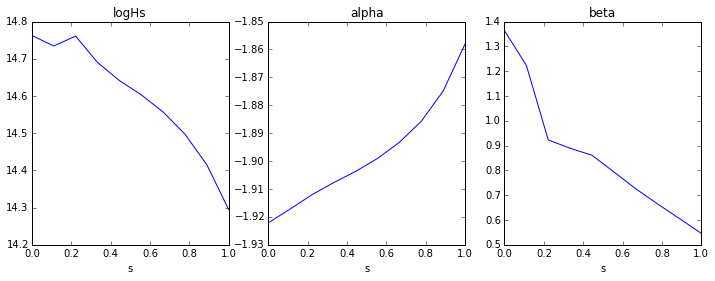

In [59]:
# Plot the results against s
fig,ax = plt.subplots(1,3,sharex=True,figsize=(12,4))
for i,label in enumerate(['logHs','alpha','beta']):
    ax[i].plot(s,res[:,i])
    ax[i].set_title(label)
    ax[i].set_xlabel("s")

At this point, the choice of the weight scale becomes a matter of debate. It seems that the effect of the high mass haloes in this sample are to reduce $\beta$ -- indicating that there may be some outlier(s) which if taken into account strongly mean that the function cannot turn over very steeply. In fact, looking at the data, this is the case. The highest mass halo is ~$10^{16} h^{-1} M_\odot$ with the next just over $10^{15} h^{-1}M_\odot$. 

There is probably no "right" answer here, but we will choose to use a weighting of 0.5 for the rest of the example, since results seems to exhibit a slightly flatter dependence on it at this value, and the results here accord better with other experience of best-fitting functions at redshift 0.

### Fitting with MCMC

In [87]:
# Create the fitting class instance. This will have uniform priors.
fitobj = PerObjFit(m,nm,weight_scale=0.5,
                    alpha_bounds = (-1.99,-1.5), hs_bounds=(12,16),beta_bounds=(0.2,1.5))

# Run the mcmc. 
# We set 100 chains to warmup, but we can extend this later if we need to manually.
# Also, we start the chains in a small ball around the best (downhill) optimization solution using opt_init=True.
fitobj.run_mcmc(nchains=50,warmup=100,iterations=300,opt_init=True,threads=8)

First off we want to look at a few key diagnostics of the chain to check whether everything's okay.

In [88]:
print "Acceptance fraction (min, max, mean): ", fitobj.mcmc_res.acceptance_fraction.min(), fitobj.mcmc_res.acceptance_fraction.max(), fitobj.mcmc_res.acceptance_fraction.mean() 
print "Autocorrelation length: ", fitobj.mcmc_res.acor

Acceptance fraction (min, max, mean):  0.55 0.7 0.648333333333
Autocorrelation length:  [ 16.07339567   7.56804103  14.37203847]


These acceptance fractions are somewhat high, but probably okay. We also note that we've included in our sample at least 10 autocorrelation lengths for each parameter, which means that our sample is probably fairly robust. We'll check burnin as well soon.

Since the fitting takes some time, we save the main results, i.e. the chain, to file here so that we can begin again at any time without running the MCMC. Thus the following analysis only uses the chains as written to file, rather than the full fit objects just created.

In [89]:
np.savez("n2gc_analysis/n2gc_mcmc_chain",chain=fitobj.mcmc_res.chain)

In [90]:
chain = np.load("n2gc_analysis/n2gc_mcmc_chain.npz")['chain']

## Analysis

### Traceplot
The first thing we might want to do with each fit is to check its traceplot, and determine if the burnin was sufficient. 

In [24]:
def traceplot(keys,chains):
    f, ax = plt.subplots(len(keys), 1, sharex=True, figsize=(8, 2.5 * len(keys)))
    for i, (key, chain) in enumerate(zip(keys,chains.T)):
        ax[i].plot(chain, color="black", alpha=0.2)
        ax[i].set_ylabel(key,fontsize=16)
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    return f

Plot both cases:

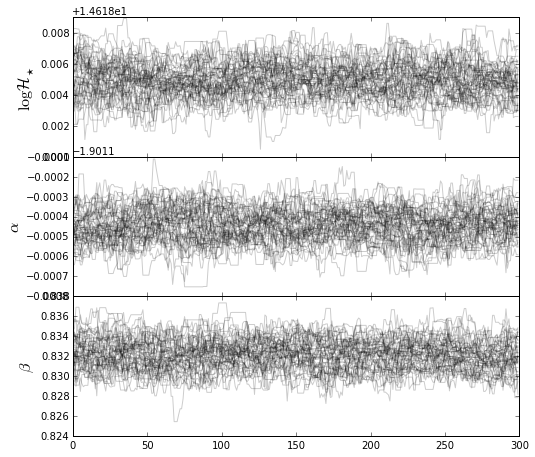

In [91]:
fig0 = traceplot([r"$ \log \mathcal{H}_\star$",r"$\alpha$",r'$\beta$'],chain)

It seems like a reasonable burn-in time has been met, so we're happy we trust our sample.

### Basic Results

We'd like to know the pure basic results: mean, median, mode, standard deviation etc.

In [105]:
print "Mean: ", np.mean(chain,axis=(0,1))
print "Median: ", np.median(chain,axis=(0,1))
print "Mode: ", fitobj.mcmc_res.flatchain[np.argmax(fitobj.mcmc_res.flatlnprobability),:]
print "Std Dev.: ", np.std(chain,axis=(0,1))
print "Covariance: ", np.cov(chain.reshape((-1,3)).T)
print "Relative Uncertainty: ", np.std(chain,axis=(0,1))*100/np.mean(chain,axis=(0,1))
from mrpy.core import log_mass_mode
print "Log Mass Mode: ", np.log10(log_mass_mode(*np.mean(chain,axis=(0,1))))

Mean:  [ 14.62297113  -1.90154239   0.83216201]
Median:  [ 14.6229667   -1.90154217   0.83217805]
Mode:  [ 14.6228914   -1.90154169   0.83211199]
Std Dev.:  [  1.09614253e-03   8.30784772e-05   1.51727589e-03]
Covariance:  [[  1.20160855e-06  -4.89580549e-08   5.14371570e-07]
 [ -4.89580549e-08   6.90249354e-09  -6.34923989e-08]
 [  5.14371570e-07  -6.34923989e-08   2.30227962e-06]]
Relative Uncertainty:  [ 0.00749603 -0.004369    0.18232939]
Log Mass Mode:  13.5090551065


### Corner plot

This produces a "corner" plot which shows the covariance between parameters.

In [93]:
import corner

def  corner_plot(chain):
    # Merge walkers and iterations axes
    flatchain = chain.copy().reshape((-1,3))
    
    # Get the mean of each parameter
    mean = np.mean(flatchain, axis=0)
    
    # Get a chain re-centred to the mean
    flatchain -= mean
    

    figure = corner.corner(flatchain, 
                           bins=20,
                           smooth=0.6,
                           labels=[r"$ \log \mathcal{H}_\star - %.4f$"%mean[0],
                                   r"$\alpha + %.5f$"%(-mean[1]),
                                   r'$\beta - %.4f$'%mean[2]],
                             label_kwargs={"fontsize":16},
                             range = [0.99,0.99,0.99],
                             quantiles=[0.16, 0.5, 0.84],
                             plot_contours = True,
                             use_math_text=True,
                             top_ticks=False)
                             
                             #plot_ellipse=True, plot_datapoints=False, kde=True,
                            #fontsize=16,lw=2)

    return figure

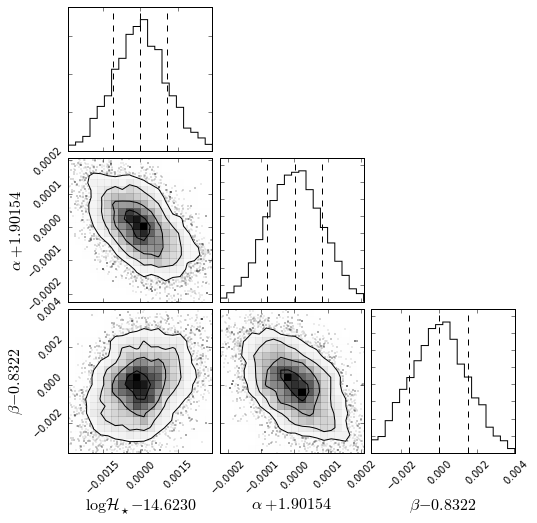

In [102]:
cornerfig0 = corner_plot(chain)
cornerfig0.savefig("../../mrpArticle/figures/n2gc_triangle.pdf")

### Residual Plot

Importantly, we want to check if the actual results look good against the data, when binned.

In [95]:
# Generate total density of each sim
rho = [np.sum(x*nx)/L**3 for x,nx,L in zip(m,nm,[140.0,560.0])]

# A function to create histograms from raw masses, and conver them to dn/dm.
# It also sets edge values in which a whole bin is not sampled to nan for visual purposes.
def bin_masses(masses,nm, V, bins=50):
    hist, edges = np.histogram(np.log10(masses), bins,weights=nm)
    centres = (edges[1:] + edges[:-1]) / 2
    dx = centres[1] - centres[0]
    hist = hist.astype("float") / (10 ** centres * float(V) * dx * np.log(10))
    
    try:
        hist0 = np.where(hist != 0)[0][0]
        hist[hist0] = 0
    except IndexError:
        pass
    
    try:
        histN = np.where(hist != 0)[0][-1]
        hist[histN] = 0
    except IndexError:
        pass
    
    hist[hist == 0] = np.nan
    return centres, hist


# Calculate the total mmin and mmax for all sims in the suite
mmin = np.min([x.min() for x in m])
mmax = np.max([x.max() for x in m])

# Generate the bin structure
bins = np.linspace(np.log10(mmin), np.log10(mmax),50)
bin_centres = (bins[1:] + bins[:-1])/2

# Generate the dn/dm from the sims
dndm = []
for mi,nmi,L in zip(m,nm,[140.0,560.0]):
    dndm.append(bin_masses(mi,nmi,L**3,bins)[1])
    
# Save the mean of the data
mean = np.mean(chain,axis=(0,1))

# Generate the best normalisation. The normalisation is *not fit*, but rather matched to the data
# after fitting. We make it equal to a weighted average of normalisations required to match the 
# mass density of each simulation.
req_a = []
for mi,nmi,rhoi in zip(m,nm,rho):
    fit = MRP(logm = mi,logHs=mean[0],alpha=mean[1],beta=mean[2],norm=0.0,log_mmin=np.log10(mi.min()))
    req_a.append(np.log(rhoi/fit.rhobar))
req_a = np.average(req_a,weights=[np.sum(x) for x in nm])

# The final best-fit object.
fit = MRP(logm = bin_centres,logHs=mean[0],alpha=mean[1],beta=mean[2],norm=req_a)

Along with the best-fit MRP, we want to show the published mass function of the data, which we get from the hmf package.

In [83]:
from hmf import MassFunction

h = MassFunction(hmf_model="Ishiyama", cut_fit=False, cosmo_params={"Om0":0.31, "Ob0":0.048, "H0":68.0},
                 sigma_8=0.83, n=0.96,lnk_min=-15, lnk_max=15, dlnk=0.01,Mmin=bin_centres[0],Mmax=bin_centres[-1],
                dlog10m=bin_centres[1]-bin_centres[0])

We'll also plot the Rockstar-derived mass function on the same plot, to gauge the relative differences between the MRP fit and the effects of the halo finder

In [84]:
# Import all rockstar data
mrock, nmrock = get_raw_data(sims=['m'],ftype="rockstar")

# Generate the dn/dm from the sim
dndm_rock = bin_masses(mrock,nmrock,560.**3,bins)[1]

Finally we draw the actual plot.

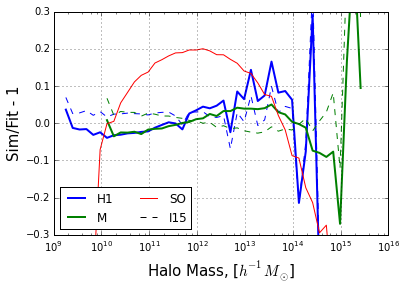

In [101]:
for i,(dn,label,col) in enumerate(zip(dndm,
                                      ["H1","M"],
                                      ["b",'g'])):
    # Residuals to MRP
    plt.plot(10**bin_centres,dn/fit.dndm() - 1,label=label,color=col,lw=2)
        
    # Residuals to published function
    plt.plot(10**bin_centres, dn/h.dndm -1, ls="--",color=col)
    
# Rsidual of Rockstar to MRP
plt.plot(10**bin_centres,dndm_rock/fit.dndm() -1, color="r",label="SO")

# Legend item for I15 fit
plt.plot([0],[0],label="I15",ls="--",color="k")

# PLOT STYLING
plt.xscale('log')
plt.grid(True)
plt.ylim((-0.3,0.3))
plt.xlabel(r"Halo Mass, [$h^{-1}M_\odot$]",fontsize=15)
plt.ylabel("Sim/Fit - 1",fontsize=15)
plt.legend(loc=0,ncol=2)

plt.savefig("../../mrpArticle/figures/n2gc_fof_simul.pdf")

We notice that the residuals from MRP are very similar in magnitude to those from the full EPS-based fit, over a fairly wide range of masses. Note that it seems that the MRP will diverge more significantly below the mass threshold than the EPS fit. In any case, both diverge significantly less than the *same simulation* with haloes found with a spherical overdensity technique (i.e. rockstar). 